In [2]:
%pip install numpy matplotlib

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 8.4 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 10.7 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 11.0 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.0 MB/s  0:00:00
Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.7 MB/s  0:00:00
   -----------------

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
from math import ceil

In [4]:
# Parâmetros (configuráveis)
DURACAO_SIMULACAO_MIN = 30 
DURACAO_SIMULACAO_SEC = DURACAO_SIMULACAO_MIN * 60
CICLO_PADRAO = 60
LARGURA_TRAVESSIA = 10   
VEL_PED = 0.97             
TEMPO_TRAVESSIA = int(np.ceil(LARGURA_TRAVESSIA / VEL_PED))
G_MIN = TEMPO_TRAVESSIA + 5
G_MAX = 90
SENSOR_RUIDO_PCT = 0.15
GAP_THRESHOLD = 5 
MEDIA_CARROS_A = 20         
MEDIA_CARROS_B = 18   
PROB_PEDESTRE = 0.3        
PROB_PRIORIDADE = 0.05  
TAXA_ESCOAMENTO = 0.6        # veículos/s quando verde (~36 veic/min)
SIM_DT = 1                
SAMPLE_RATE = 3           
MAX_SNAPSHOTS = 200       
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Simulação configurada para {DURACAO_SIMULACAO_MIN} minutos.")
print(f"Tempo mínimo de verde para a segurança do pedestre: {G_MIN} segundos.")

Simulação configurada para 30 minutos.
Tempo mínimo de verde para a segurança do pedestre: 16 segundos.


In [ ]:
def ruido_sensor(valor_real, erro_max=SENSOR_RUIDO_PCT):
    # Adiciona ruído percentual ao valor real.
    if valor_real <= 0: return 0
    
    fator = 1 + random.uniform(-erro_max, erro_max)
    valor_ruidoso = int(valor_real * fator)
    return max(0, valor_ruidoso)

def gerar_fluxo_carros(taxa_media_minuto, tempo_decorrido_sec):
    # Usa Poisson: A probabilidade de X carros chegarem num intervalo de tempo.
    lambda_poisson = (taxa_media_minuto / 60) * tempo_decorrido_sec
    chegadas = np.random.poisson(lambda_poisson)
    return chegadas

def detectar_prioridade(probabilidade):
    # Retorna True se houver Ambulância, Bombeiro ou Ônibus detectado.
    return random.random() < probabilidade

def detectar_pedestre(probabilidade):
    # Retorna True se botão de pedestre foi acionado ou detecção visual.
    return random.random() < probabilidade

In [ ]:
class Vehicle:
    def __init__(self, id, is_bus=False):
        self.id = id
        self.is_bus = is_bus
        self.pos = -random.uniform(2, 20)
        self.speed = 0.0
        self.wait_time = 0.0

class Lane:
    def __init__(self, name):
        self.name = name
        self.vehicles = deque()
        self.passed = 0

    def add_vehicles(self, n, start_id, bus_prob=0.0):
        for i in range(n):
            is_bus = random.random() < bus_prob
            v = Vehicle(start_id + i, is_bus=is_bus)
            self.vehicles.append(v)
        return n

    def queue_length(self):
        return len(self.vehicles)

    def step_during_green(self, discharge_rate, dt):
        # Calcula quantos carros podem passar baseada na "Taxa de Escoamento" (Saturation Flow)
        expected = discharge_rate * dt

        base = int(np.floor(expected))
        frac = expected - base
        extra = 1 if random.random() < frac else 0
        capacity = base + extra

        passed_now = 0
        waited_sum = 0.0
        for _ in range(capacity):
            if not self.vehicles:
                break
            v = self.vehicles.popleft()
            waited_sum += v.wait_time
            self.passed += 1
            passed_now += 1
        for veh in self.vehicles:
            # Move os carros na fila visualmente
            veh.pos += min(1.5 * dt, 5.0) 
        return passed_now, waited_sum

    def step_during_red(self, dt):
        for veh in self.vehicles:
            veh.wait_time += dt

class ActuatedController:
    def __init__(self, laneA, laneB):
        self.laneA = laneA
        self.laneB = laneB
        self.phase = 'A'
        self.phase_time = 0
        self.green_time = {'A': G_MIN, 'B': G_MIN}
        self.total_priority_count = 0

    def sense(self):
        detA = ruido_sensor(self.laneA.queue_length())
        detB = ruido_sensor(self.laneB.queue_length())
        return detA, detB

    def decide(self, t, ped_A, ped_B, v2i_A, v2i_B):
        detA, detB = self.sense() # Lê sensores com ruído
        
        # 1. Lógica de Prioridade (Ambulância/Ônibus)
        if self.phase == 'A' and v2i_A:
             # Se tem prioridade, força o verde a durar até o máximo possível
            self.green_time['A'] = min(G_MAX, max(self.green_time['A'], G_MAX))

        # 2. Lógica de Troca (Switch Logic) para Fase A
        if self.phase == 'A':
            # Se pedestre apertou botão e já passou o tempo mínimo: TROCA
            if ped_B and self.phase_time >= G_MIN: return 'switch'
            
            # Se fila está vazia (Gap-Out) e já passou o mínimo: TROCA
            if detA <= 1 and self.phase_time >= G_MIN:
                 return 'switch' if detB > 0 else 'hold' # Só troca se tiver gente na outra via
            
            # Se estourou o tempo máximo (Max-Out): TROCA
            if self.phase_time >= G_MAX: return 'switch' 
            
            return 'hold' # Mantém verde

    def step(self, t, dt, ped_A, ped_B, v2i_A, v2i_B):
        action = self.decide(t, ped_A, ped_B, v2i_A, v2i_B)
        if action == 'hold':
            self.phase_time += dt
        elif action == 'switch':
            self.phase = 'B' if self.phase == 'A' else 'A'
            self.phase_time = 0
            qA = max(1, self.laneA.queue_length())
            qB = max(1, self.laneB.queue_length())
            total = qA + qB
            splitA = int(np.clip(round(CICLO_PADRAO * (qA/total)), G_MIN, G_MAX))
            splitB = int(np.clip(round(CICLO_PADRAO * (qB/total)), G_MIN, G_MAX))
            self.green_time['A'] = splitA
            self.green_time['B'] = splitB
        return self.phase

Simulação finalizada.
Total veículos que passaram: 1062
 - Via A: 556
 - Via B: 506
Tempo médio estimado de espera por veículo: 40.55 s
Eventos de prioridade detectados (V2I): 140


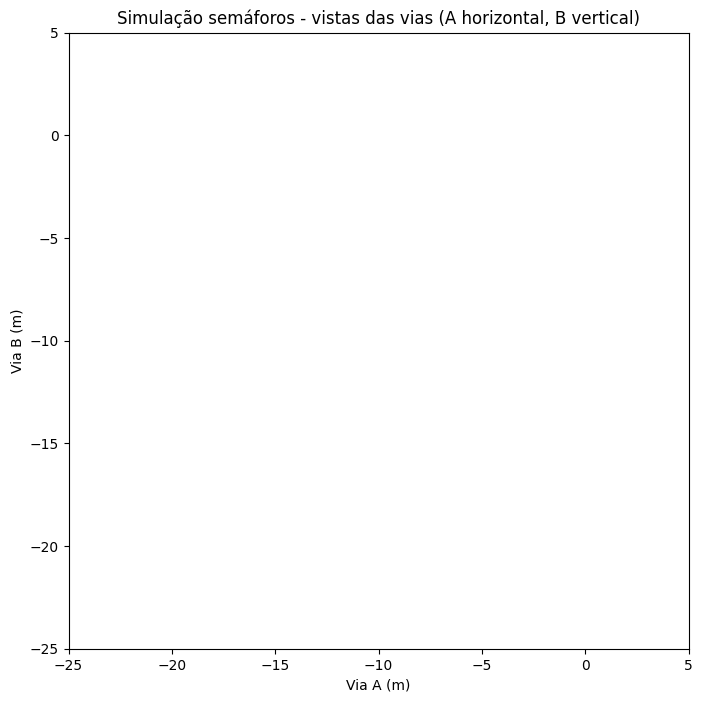

In [7]:
def run_simulation():
    laneA = Lane('A')
    laneB = Lane('B')
    controller = ActuatedController(laneA, laneB)

    t = 0
    vehicle_id = 0
    snapshots = []
    snapshot_times = []

    total_passed = 0
    total_wait_passed = 0.0
    total_priority_events = 0

    while t < DURACAO_SIMULACAO_SEC:
        chegA = gerar_fluxo_carros(MEDIA_CARROS_A, SIM_DT)
        chegB = gerar_fluxo_carros(MEDIA_CARROS_B, SIM_DT)
        laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegA
        laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegB

        ped_A = detectar_pedestre(PROB_PEDESTRE * (SIM_DT/1.0))
        ped_B = detectar_pedestre(PROB_PEDESTRE * (SIM_DT/1.0))
        v2i_A = detectar_prioridade(PROB_PRIORIDADE * (SIM_DT/1.0))
        v2i_B = detectar_prioridade(PROB_PRIORIDADE * (SIM_DT/1.0))

        current_phase = controller.step(t, SIM_DT, ped_A, ped_B, v2i_A, v2i_B)

        if current_phase == 'A':
            passed, waited_sum = laneA.step_during_green(TAXA_ESCOAMENTO, SIM_DT)
            laneB.step_during_red(SIM_DT)
        else:
            passed, waited_sum = laneB.step_during_green(TAXA_ESCOAMENTO, SIM_DT)
            laneA.step_during_red(SIM_DT)

        total_passed += passed
        total_wait_passed += waited_sum

        if v2i_A or v2i_B:
            total_priority_events += 1

        if (t % SAMPLE_RATE == 0) and (len(snapshots) < MAX_SNAPSHOTS):
            snap = {
                't': t,
                'phase': controller.phase,
                'laneA_positions': [v.pos for v in laneA.vehicles],
                'laneB_positions': [v.pos for v in laneB.vehicles],
                'queueA': laneA.queue_length(),
                'queueB': laneB.queue_length(),
                'passedA': laneA.passed,
                'passedB': laneB.passed
            }
            snapshots.append(snap)
            snapshot_times.append(t)

        t += SIM_DT

    avg_wait = total_wait_passed / max(1, total_passed)
    metrics = {
        'total_passed': total_passed,
        'passedA': laneA.passed,
        'passedB': laneB.passed,
        'avg_wait_per_vehicle': avg_wait,
        'total_priority_events': total_priority_events,
        'snapshots': snapshots,
        'snapshot_times': snapshot_times
    }
    return metrics

# Execute
metrics = run_simulation()
print("Simulação finalizada.")
print("Total veículos que passaram:", metrics['total_passed'])
print(" - Via A:", metrics['passedA'])
print(" - Via B:", metrics['passedB'])
print(f"Tempo médio estimado de espera por veículo: {metrics['avg_wait_per_vehicle']:.2f} s")
print("Eventos de prioridade detectados (V2I):", metrics['total_priority_events'])

# Visualização (animação usando snapshots gravados)
snaps = metrics['snapshots']
if snaps:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(-25, 5)
    ax.set_ylim(-25, 5)
    ax.set_title("Simulação semáforos - vistas das vias (A horizontal, B vertical)")
    ax.set_xlabel("Via A (m)")
    ax.set_ylabel("Via B (m)")
    scatA = ax.scatter([], [], s=40)
    scatB = ax.scatter([], [], s=40)
    phase_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    info_text = ax.text(0.02, 0.88, '', transform=ax.transAxes)

    def init():
        scatA.set_offsets(np.empty((0,2)))
        scatB.set_offsets(np.empty((0,2)))
        phase_text.set_text('')
        info_text.set_text('')
        return scatA, scatB, phase_text, info_text

    def update(frame):
        snap = snaps[frame]
        xA = snap['laneA_positions']; yA = [-1.5] * len(xA)
        ptsA = np.column_stack([xA, yA]) if len(xA) > 0 else np.empty((0,2))
        xB = [-1.5] * len(snap['laneB_positions']); yB = snap['laneB_positions']
        ptsB = np.column_stack([xB, yB]) if len(yB) > 0 else np.empty((0,2))
        scatA.set_offsets(ptsA); scatB.set_offsets(ptsB)
        phase_text.set_text(f"Tempo = {snap['t']} s | Fase = {snap['phase']}")
        info_text.set_text(f"Fila A: {snap['queueA']}  Fila B: {snap['queueB']}  Passados A:{snap['passedA']} B:{snap['passedB']}")
        return scatA, scatB, phase_text, info_text

    ani = animation.FuncAnimation(fig, update, frames=len(snaps), init_func=init,
                                  interval=80, blit=True, repeat=False)
    plt.show()